In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Reader():

    def __init__(self, file_name):
        self.file_name = file_name
        self.nparticles = 14
        self.timestep, self.runsteps, self.log_frequency = self.get_metadata()
        self.n_logged_timesteps = int(self.runsteps/self.log_frequency + 1)
        self.logged_timesteps = np.arange(0, self.runsteps+1, self.log_frequency)
    
    def read_original_traj(self, save=True):
        subfix = '-traj.dump'
        lines = []
        with open(self.file_name+subfix, 'r') as f:
            particles_counter = 0
            particles_temp = []
            log_count = 0
            for i, line in enumerate(f):   
                if particles_counter == self.nparticles:
                    particles_temp = np.array(particles_temp, dtype=float)
                    particles_temp = particles_temp[particles_temp[:, 2].argsort()]
                    lines.append(particles_temp)
                    particles_counter = 0
                    particles_temp = []
                    log_count += 1
                    continue
                elif particles_counter > 0:
                    line = line.rstrip(' \n')
                    line = line.split()
                    line.pop(1) # remove 'type' column
                    particles_temp.append([str(self.logged_timesteps[log_count]), self.body_id(line[0])]+line)
                    particles_counter += 1
                else:
                    if i == 8:
                        line = line.lstrip('ITEM: ATOMS ')
                        labels = line.split()
                        labels.remove('type')
                        labels = ['timestep', 'body_id'] + labels
                    if (i-9) % 23 == 0:
                        line = line.rstrip(' \n')
                        line = line.split()
                        line.pop(1) # remove 'type' column
                        particles_temp.append([str(self.logged_timesteps[log_count]), self.body_id(line[0])]+line)
                        particles_counter += 1
        
        lines = np.vstack(lines)
        if save:
            df = pd.DataFrame(lines, columns=labels)
            df.to_csv(self.file_name+'-original_traj.csv', index=False)
            
        return labels, lines

    def read_reduced_traj(self, save=True):
        subfix = '-info.dat'
        lines = []
        log_count = 0
        with open(self.file_name+subfix, 'r') as f:
            for i, line in enumerate(f):
                if i == 8:
                    line = line.lstrip('ITEM: ENTRIES ')
                    labels = ['timestep'] + line.split()
                if (i+1) % 10 == 0:
                    line = line.rstrip(' \n')
                    line = [str(self.logged_timesteps[log_count])] + line.split()
                    lines.append(line)
                    log_count += 1
        lines = np.array(lines, dtype=float)

        # TODO: add a column for body_id rather than have so many columns
        if save:
            df = pd.DataFrame(lines, columns=labels)
            df.to_csv(self.file_name+'-reduced_traj.csv', index=False)
        
        return labels, lines

    def read_simulation_log(self):
        # TODO: is this useful for anything? make this useful
        # FIX: it does not even work
        subfix = '-sim.log'
        lines = np.zeros([])
        with open(self.file_name+subfix, 'r') as f:
            for i, line in enumerate(f):
                if i < 64:
                    continue
                if i == 64:
                    label = line.split()
                    lines = np.zeros([self.n_logged_timesteps, len(label)])
                    step_no = 0
                else:
                    line = line.rstrip(' \n')
                    line = line.split()
                    try:
                        line = np.array(line, dtype=float)
                    except ValueError:
                        print(f"Breaking - likely reached last line of sim log: {line}")
                        break
                    lines[step_no] = line
                    step_no += 1
        
        return label, lines

    def get_metadata(self):
        subfix = '-input.log'
        with open(self.file_name+subfix, 'r') as f:
            counter = 0
            for i, line in enumerate(f):
                if line == '\n':
                    continue
                else:
                    counter += 1
                    if counter == 2:
                        log_frequency = int(line.split()[3])
                    elif counter == 3:
                        runsteps = int(line.split()[3])
                    elif counter == 4:
                        timestep = float(line.split()[3])
                        break

        print(f"Found timestep: {timestep}, n of run steps: {runsteps}, and dump log freq: {log_frequency}")
        return timestep, runsteps, log_frequency

    def body_id(self, atom_id):
        if (int(atom_id)) <= (self.nparticles // 2):
            return 1
        else:
            return 2 

In [75]:
# Read files
K = 0.01
R0 = 3
T = 0.2
SEED = 5
# file_name = f'NVE-temp-{T}_K-{K}_r-{R0}_s-{SEED}'
# prefix = 'hexagons/trajectories/dump_2303/'
# file_name = prefix+'NVE-temp-0.2_K-0.493827160493827_r-0_s-5'
prefix = 'hexagons/trajectories/inertia_issue/'
file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)

Found timestep: 1e-06, n of run steps: 10000000, and dump log freq: 100


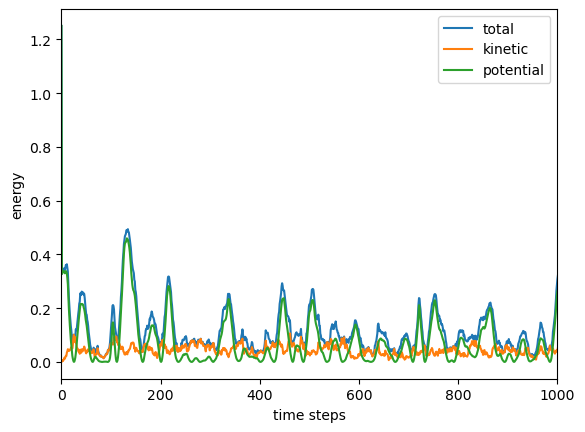

In [2]:
kineticEnergy = log_lines[:, -2]
forceMagnitude = log_lines[:, 4]

# x_diff = traj_lines[:, 0] - traj_lines[:, 3]
# y_diff = traj_lines[:, 1] - traj_lines[:, 4]
# z_diff = traj_lines[:, 2] - traj_lines[:, 5]
# com_distance = np.sqrt(x_diff**2 + y_diff**2 + z_diff**2)

k = 0.1
r0 = 5.0 
com_distance = np.linalg.norm(traj_lines[:, 0:3] - traj_lines[:, 3:6], axis=1)
potentialEnergy = 0.5 * k * (com_distance - r0)**2
# is this the correct way to calculate all of this?

totalEnergy = kineticEnergy + potentialEnergy

# print(com_distance[2])
# print(totalEnergy.shape)
# print(potentialEnergy.shape)

plt.plot(totalEnergy, label='total')
plt.plot(kineticEnergy, label='kinetic')
plt.plot(potentialEnergy, label='potential')
plt.xlabel('time steps')
plt.ylabel('energy')
plt.legend()
plt.xlim(0, 1000)
# plt.ylim(0, 0.2)
plt.show()


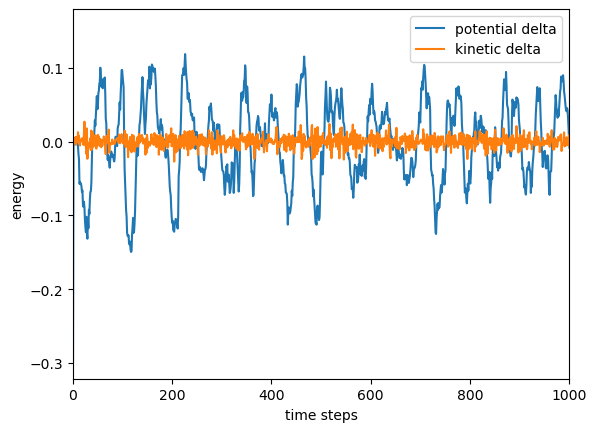

In [3]:
deltaPotential = - k / 2 * (com_distance[1:]**2 - com_distance[:-1]**2)
deltaKinetic = kineticEnergy[1:] - kineticEnergy[:-1]

plt.plot(deltaPotential, label='potential delta')
plt.plot(deltaKinetic, label='kinetic delta')
plt.xlim(0, 1000)
plt.xlabel('time steps')
plt.ylabel('energy')
plt.legend()
plt.show()

In [138]:
print(log_lines[:20, 4])
q = np.sqrt(log_lines[:20, 1]**2 + log_lines[:20, 2]**2 + log_lines[:20, 3]**2) 
print(q)

[-0.01821793 -0.01826263 -0.01840154 -0.01851226 -0.01856435 -0.01855492
 -0.01844083 -0.01834017 -0.01847531 -0.01856517 -0.01849526 -0.01831862
 -0.0178325  -0.01717194 -0.0156663  -0.01432805 -0.01300073 -0.01175871
 -0.01050121 -0.00915952]
[0.01821793 0.01826263 0.01840154 0.01851226 0.01856435 0.01855492
 0.01844083 0.01834017 0.01847531 0.01856516 0.01849526 0.01831862
 0.0178325  0.01717194 0.0156663  0.01432805 0.01300073 0.01175871
 0.01050121 0.00915952]


In [139]:
kineticEnergy = log_lines[:, -2]
forceMagnitude = log_lines[:, 4]

def moving_average(x, w=50):
    return np.convolve(x, np.ones(w), 'valid') / w

# x_diff = traj_lines[:, 0] - traj_lines[:, 3]
# y_diff = traj_lines[:, 1] - traj_lines[:, 4]
# z_diff = traj_lines[:, 2] - traj_lines[:, 5]
# com_distance = np.sqrt(x_diff**2 + y_diff**2 + z_diff**2)

com_distance = np.linalg.norm(traj_lines[:, 0:3] - traj_lines[:, 3:6], axis=1)
potentialEnergy = - 0.5 * K * (com_distance**2 - R0**2)
# is this the correct way to calculate all of this? yes, I believe so

totalEnergy = log_lines[:,-1]
totalReducedEnergy = totalEnergy - potentialEnergy

plt.figure(facecolor='white')
plt.title(f"K = {K} and T = {T}")
plt.plot(moving_average(totalEnergy), label='total logged energy')
plt.plot(moving_average(totalReducedEnergy), label='total + harmonic potential)')
# plt.plot(kineticEnergy, label='kinetic (total logged energy)')
# plt.plot(potentialEnergy, label='calculated harmonic potential')
plt.xlabel('time steps')
plt.ylabel('energy')
plt.legend()
plt.show()

# DELTA PLOT

# deltaPotential = - K / 2 * (com_distance[1:]**2 - com_distance[:-1]**2)
deltaReduced = totalReducedEnergy[1:] - totalReducedEnergy[:-1]
deltaEnergy = totalEnergy[1:] - totalEnergy[:-1]

plt.figure(facecolor='white')
plt.plot(moving_average(deltaEnergy), label='Total Energy Change')
plt.plot(moving_average(deltaReduced), label='Total Energy (+ harmonic) Change')
plt.xlabel('Time Steps')
plt.ylabel('Energy Change')
plt.legend()
plt.show()

array([3.31892990e-04, 3.33523721e-04, 3.38616684e-04, 3.42703882e-04,
       3.44635165e-04, 3.44285009e-04, 3.40064351e-04, 3.36361735e-04,
       3.41337040e-04, 3.44665340e-04, 3.42074609e-04, 3.35571667e-04,
       3.17998077e-04, 2.94875580e-04, 2.45433062e-04, 2.05293145e-04,
       1.69019072e-04, 1.38267288e-04, 1.10275447e-04, 8.38967935e-05])

Found timestep: 1e-05, n of run steps: 1000000, and dump log freq: 1000
torch.Size([1, 1001, 2, 3])


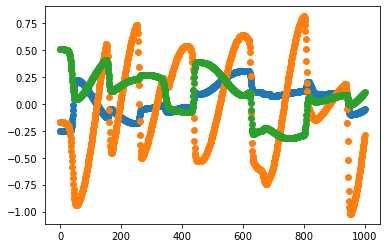

In [22]:
from data.trajectory import Trajectory
import matplotlib.pyplot as plt


traj = Trajectory('hexagons/trajectories/jakub/NVE-temp-2.25_K-17.8583270116258_r-2_s-5', 'cpu')

vel = traj.traj[0]
print(vel.shape)
plt.plot(vel[0, :, 0, :], 'o')
plt.show()

Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 1000
Breaking - likely reached last line of sim log: ['Loop', 'time', 'of', '219.559', 'on', '1', 'procs', 'for', '100000000', 'steps', 'with', '14', 'atoms']


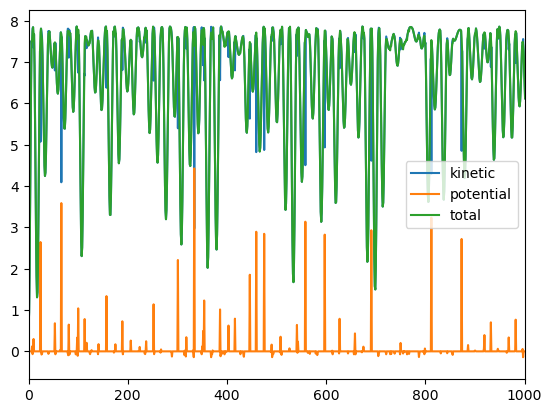

In [17]:
from data.reader import Reader
import matplotlib.pyplot as plt
import numpy as np

reader = Reader('dataset/trajectories/jakub/NVE-temp-2.25_K-17.8583270116258_r-2_s-5')

def moving_average(x, w=50):
    return np.convolve(x, np.ones(w), 'valid') / w

# print(reader.read_simulation_log()[0])
data_label, data_lines = reader.read_simulation_log()

def harmonic_energy():
    k = 17.8583270116258
    r0 = 2.0
    com_distance = data_lines[:, 4]
    return 0.5 * k * (com_distance - r0)**2

plt.plot(data_lines[:, -2], label='kinetic')
plt.plot(data_lines[:, -3], label='potential')
plt.plot(data_lines[:, -1], label='total')
# plt.plot(harmonic_energy(), label='harmonic')
plt.legend()
plt.xlim(0, 1000)
plt.show()

Index(['timestep', 'c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]', 'c_com_2[1]',
       'c_com_2[2]', 'c_com_2[3]', 'c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]',
       'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]', 'c_q_1[1]', 'c_q_1[2]',
       'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]',
       'c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]',
       'c_av_2[3]', 'c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]', 'c_am_2[1]',
       'c_am_2[2]', 'c_am_2[3]', 'c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]',
       'c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]'],
      dtype='object')


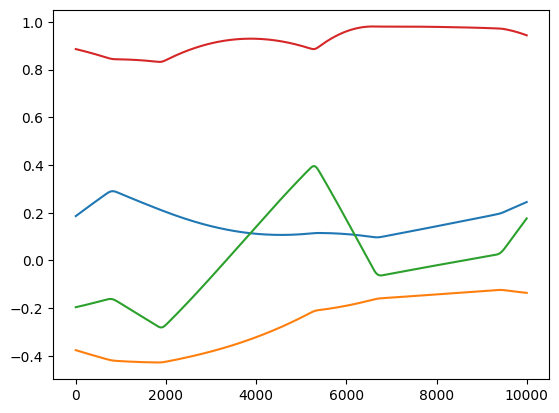

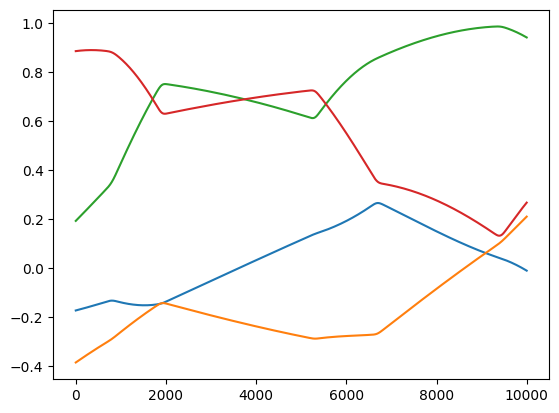

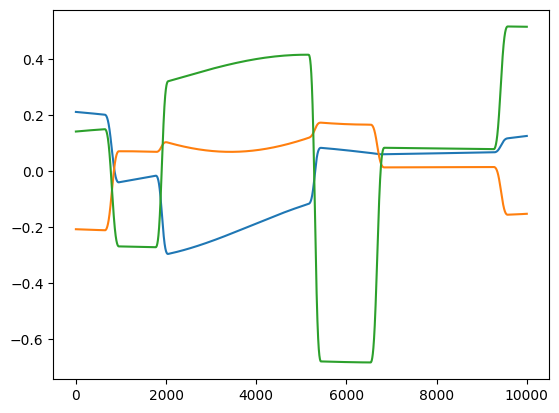

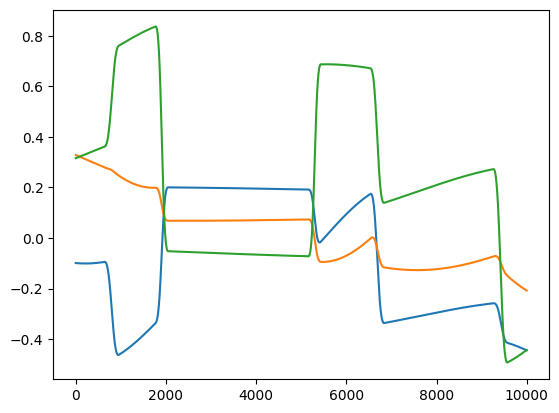

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset/trajectories/thesis/NVE-temp-0.5_K-3.96851711369462_r-2_s-5-reduced_traj.csv')
# df = pd.read_csv('dataset/smooth/NVE-temp-0.45_K-0.090702947845805_r-0_s-5-reduced_traj.csv')

print(df.columns)
# get centre of mass position and velocity
# com_pos = df.iloc[:, 1:7].values
# com_vel = df.iloc[:, 7:7+6].values

quats = df.loc[:, ['c_q_1[1]', 'c_q_1[2]',
       'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']].values

angvels = df.loc[:, ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']].values

# print(com_pos)
# print(com_vel)

# plt.plot(com_pos[:, 0])
# plt.plot(com_pos[:, 1])
# plt.plot(com_pos[:, 2])
end_index = quats.shape[0] // 100
plt.plot(quats[:end_index, 0])
plt.plot(quats[:end_index, 1])
plt.plot(quats[:end_index, 2])
plt.plot(quats[:end_index, 3])
plt.show()


plt.plot(quats[:end_index, 4])
plt.plot(quats[:end_index, 5])
plt.plot(quats[:end_index, 6])
plt.plot(quats[:end_index, 7])
plt.show()

plt.plot(angvels[:end_index, 0])
plt.plot(angvels[:end_index, 1])
plt.plot(angvels[:end_index, 2])
plt.show()

plt.plot(angvels[:end_index, 3])
plt.plot(angvels[:end_index, 4])
plt.plot(angvels[:end_index, 5])
plt.show()




In [1]:
import torch
torch.cuda.empty_cache()
from diffmd.training import Trainer
import numpy as np

config = dict(
    folder = 'dataset/trajectories/thesis/', 
    device = torch.device("cuda:0"), 
    niters = 100000,
    start_niter = 0,
    optimizer = 'Adam',
    batch_length=20,
    nbatches=600,
    learning_rate=0.035,
    nn_depth=2,
    nn_width=183,
    activation_function=None,
    load_folder='results/smooth_short/overfit/depth-2-width-183-lr-0.06700579760634158-loss-all',
    # load_folder=None,
    dtype=torch.float32,
    printing_freq=200,
    plotting_freq=500,
    stopping_freq=10000,
    scheduler='LambdaLR',
    scheduling_factor=0.85,
    scheduling_freq=1000,
    evaluation_freq=1,
    loss_func = 'all'
    )

trainer = Trainer(config)


Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 100
device = cuda:0
dataset = ['NVE-temp-0.5_K-3.96851711369462_r-2_s-5'] in dataset/trajectories/thesis/
depth = 2, width = 183
number of parameters = 36052
learning rate = 0.035, optimizer = Adam
scheduler = LambdaLR, scheduling factor = 0.85, scheduling freq = 1000
number of batches = 600, batch length = 20


In [2]:
trainer.plot_traj(0, 'results/smooth_short/overfit/depth-2-width-183-lr-0.06700579760634158-loss-all/')